In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from scipy.optimize import curve_fit

In [3]:
filemc = uproot.open("B02Kst0eeSignal-MC-2011-MagUp-RXv9-ForPIDCalib-TrackEffCorr-nTracksCorr-PIDMeerkat-HLTaligned-Flagged-L0TrigEffCorr-HLTTrigEffCorr-KinRew2D-MCweights-XGBOutput-q2BDTOutput.root")
filed = uproot.open("B02Kst0Jpsi2ee-Data-2011-MagUp-Translated-Flagged-XGBOutput-q2BDTOutput.root")
filemc.classnames()
tmc = filemc['DecayTree']
td = filed['DecayTree']
tmc.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
w_Track_Trig_Kin     | double                   | AsDtype('>f8')
Mag                  | double                   | AsDtype('>f8')
B_true_or_reco_pt    | double                   | AsDtype('>f8')
B_true_or_reco_eta   | double                   | AsDtype('>f8')
B_true_or_reco_phi   | double                   | AsDtype('>f8')
L1_true_or_reco_pt   | double                   | AsDtype('>f8')
L1_true_or_reco_eta  | double                   | AsDtype('>f8')
L1_true_or_reco_phi  | double                   | AsDtype('>f8')
L2_true_or_reco_pt   | double                   | AsDtype('>f8')
L2_true_or_reco_eta  | double                   | AsDtype('>f8')
L2_true_or_reco_phi  | double                   | AsDtype('>f8')
L1_wTRK              | double                   | AsDtype('>f8')
L2_wTRK              | double                   | AsDtype(

In [4]:
# Charger une branche sous forme de tableau NumPy


data_bpt = td["B_PT"].array()
mc_bpt = tmc["B_PT"].array() # SIGNAL

data_kpt = td["Kstar_PT"].array()
mc_kpt = tmc["Kstar_PT"].array()

data_e1pt = td["L1_PT"].array()
mc_e1pt = tmc["L1_PT"].array()

data_e2pt = td["L2_PT"].array()
mc_e2pt = tmc["L2_PT"].array()



data_mass = td["B_M"].array()
mc_mass = tmc["B_M"].array()

background_mask = data_mass > 5600 # BRUIT DE FOND

all_true_mask = ak.Array([True] * len(data_mass))
background_bpt = data_bpt[all_true_mask]  



background_bpt = data_bpt[background_mask]
background_kpt = data_kpt[background_mask]
background_e1pt = data_e1pt[background_mask]
background_e2pt = data_e2pt[background_mask]



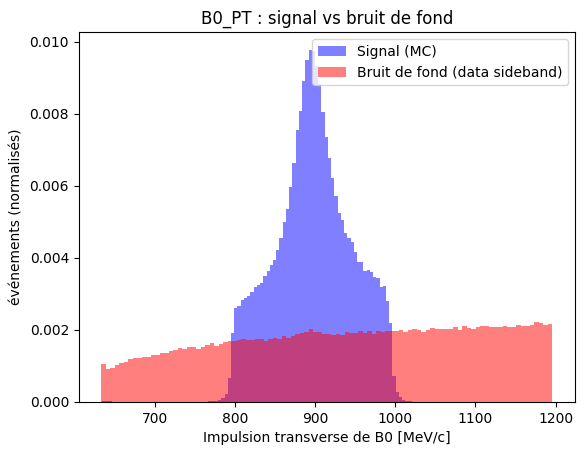

In [5]:
# Tracer un histogramme avec Matplotlib

plt.hist(tmc["B_M23"].array(), bins=100, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(td["B_M23"].array()[background_mask], bins=100, density=True, alpha=0.5, label="Bruit de fond (data sideband)", color="red")

plt.xlabel("Impulsion transverse de B0 [MeV/c]")
plt.ylabel("événements (normalisés)")
plt.legend()
plt.title("B0_PT : signal vs bruit de fond")
plt.show()


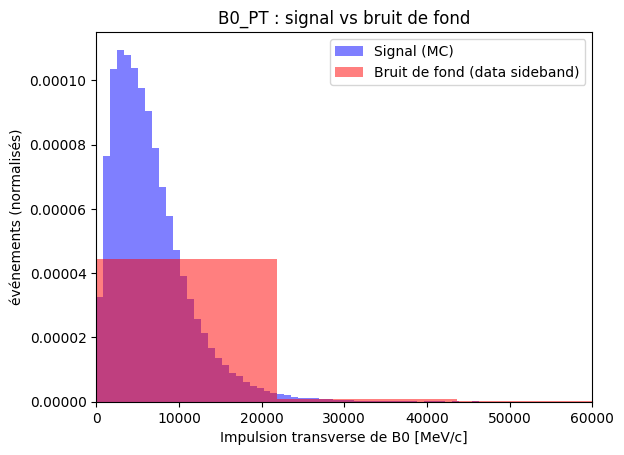

In [6]:

# Tracer un histogramme avec Matplotlib

plt.hist(mc_bpt, bins=100, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(background_bpt, bins=100, density=True, alpha=0.5, label="Bruit de fond (data sideband)", color="red")

plt.xlabel("Impulsion transverse de B0 [MeV/c]")
plt.ylabel("événements (normalisés)")
plt.legend()
plt.xlim(0, 60000)
plt.title("B0_PT : signal vs bruit de fond")
plt.show()



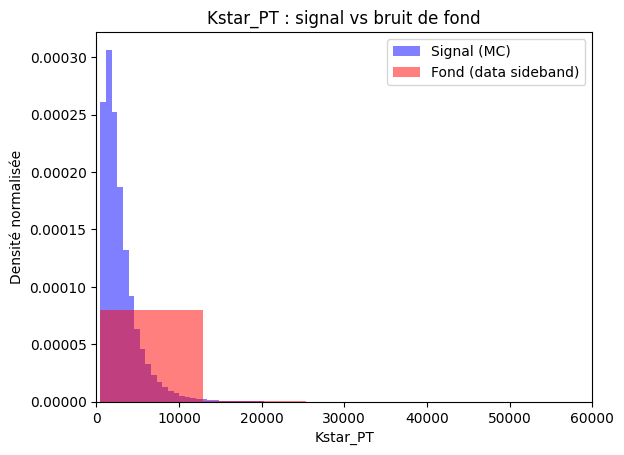

In [7]:
plt.hist(mc_kpt, bins=100, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(background_kpt, bins=100, density=True, alpha=0.5, label="Fond (data sideband)", color="red")

plt.xlabel("Kstar_PT")
plt.ylabel("Densité normalisée")
plt.legend()
plt.xlim(0, 60000)
plt.title("Kstar_PT : signal vs bruit de fond")
plt.show()

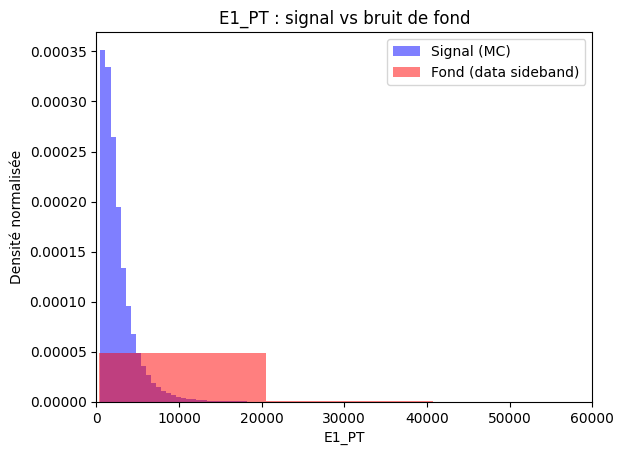

In [8]:
plt.hist(mc_e1pt, bins=100, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(background_e1pt, bins=100, density=True, alpha=0.5, label="Fond (data sideband)", color="red")

plt.xlabel("E1_PT")
plt.ylabel("Densité normalisée")
plt.legend()
plt.xlim(0, 60000)
plt.title("E1_PT : signal vs bruit de fond")
plt.show()

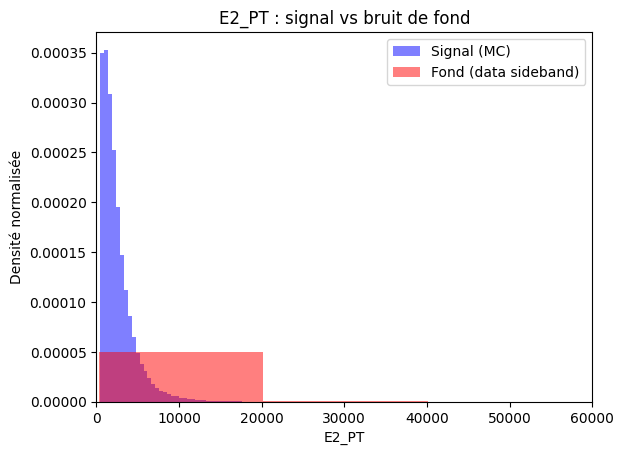

In [9]:
plt.hist(mc_e2pt, bins=100, density=True, alpha=0.5, label="Signal (MC)",color="blue")
plt.hist(background_e2pt, bins=100, density=True, alpha=0.5, label="Fond (data sideband)", color="red")

plt.xlabel("E2_PT")
plt.ylabel("Densité normalisée")
plt.legend()
plt.xlim(0, 60000)
plt.title("E2_PT : signal vs bruit de fond")
plt.show()

In [10]:

def plot_roc_awkward(discriminant, signal_maskb, thresholds):
    # Conversion en awkward array au cas où
    discriminant = ak.Array(discriminant)
    signal_maskb = ak.Array(signal_maskb)

    # Assurer la même taille
    min_len = min(len(discriminant), len(signal_maskb))
    discriminant = discriminant[:min_len]
    signal_maskb = signal_maskb[:min_len]

    # Séparer signal et fond
    sig_values = discriminant[signal_maskb]
    bkg_values = discriminant[~signal_maskb]

    signal_eff = []
    background_rej = []

    for t in thresholds:
        eff_sig = ak.sum(sig_values > t) / len(sig_values)
        eff_bkg = ak.sum(bkg_values > t) / len(bkg_values)
        rej_bkg = 1 - eff_bkg

        signal_eff.append(eff_sig)
        background_rej.append(rej_bkg)

    plt.plot(signal_eff, background_rej, color='black')
    plt.xlabel("Signal efficiency", fontsize=12, weight='bold')
    plt.ylabel("Background rejection", fontsize=12, weight='bold')
    plt.grid(True)
    plt.ylim(0.2, 1.01)
    plt.xlim(0, 1.01)
    plt.show()




In [11]:

# Fusionner les valeurs
all_ptsb = ak.concatenate([mc_bpt, background_bpt])
all_ptsk = ak.concatenate([mc_kpt, background_kpt])
all_ptse1 = ak.concatenate([mc_e1pt, background_e1pt])
all_ptse2 = ak.concatenate([mc_e2pt, background_e2pt])

# Créer le masque : True = signal, False = fond
signal_maskb = ak.concatenate([
    ak.Array([True] * len(mc_bpt)),
    ak.Array([False] * len(background_bpt))
])
signal_maskk = ak.concatenate([
    ak.Array([True] * len(mc_kpt)),
    ak.Array([False] * len(background_kpt))
])
signal_maske1 = ak.concatenate([
    ak.Array([True] * len(mc_e1pt)),
    ak.Array([False] * len(background_e1pt))
])
signal_maske2 = ak.concatenate([
    ak.Array([True] * len(mc_e2pt)),
    ak.Array([False] * len(background_e2pt))
])

thresholds = np.linspace(0, 20000, 200)



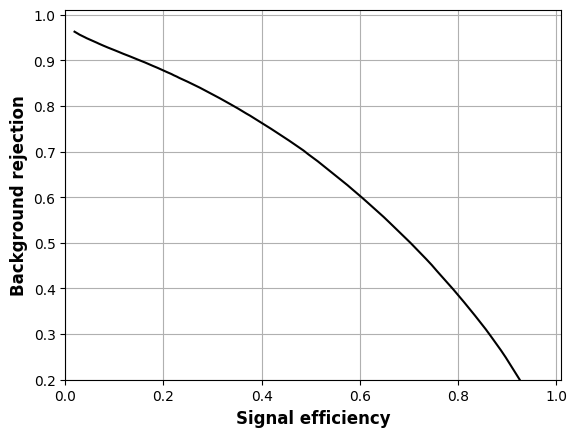

In [12]:
plot_roc_awkward(all_ptsb, signal_maskb, thresholds)

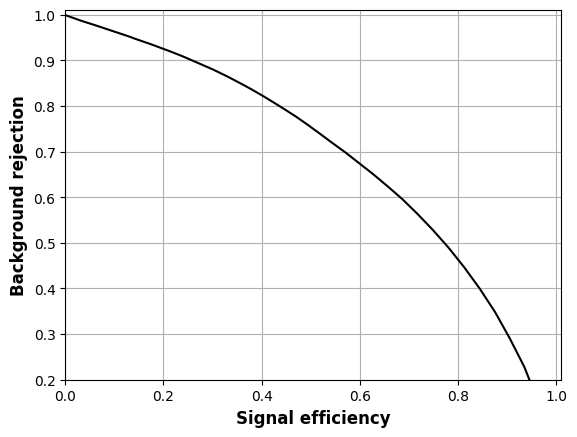

In [13]:
plot_roc_awkward(all_ptsk, signal_maskk, thresholds)

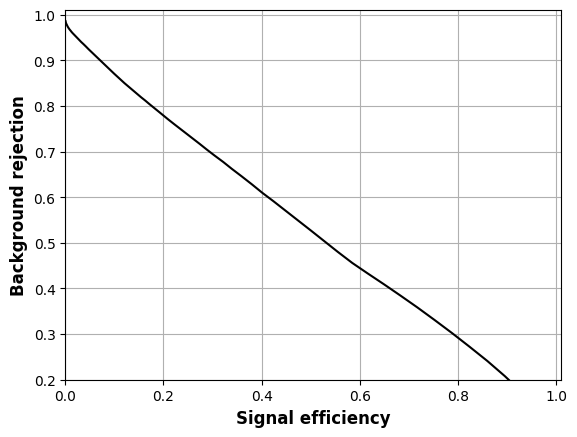

In [14]:
plot_roc_awkward(all_ptse1, signal_maske1, thresholds)

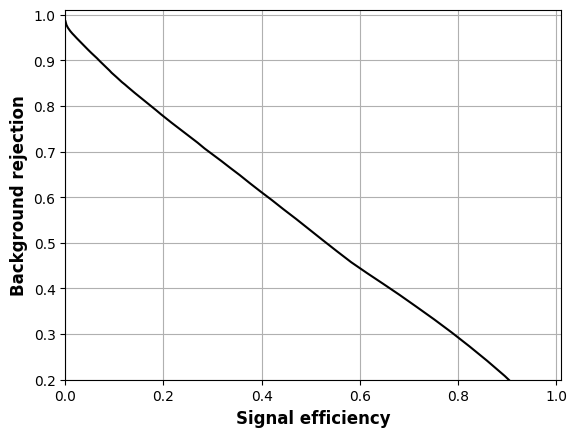

In [15]:
plot_roc_awkward(all_ptse2, signal_maske2, thresholds)

In [16]:


def calculer_eff_rejet(signal_maskb, cut_mask, verbose=True):
    """
    Calcule l'efficacité du signal et le rejet du fond, en pourcentages.

    Args:
        signal_maskb (ak.Array): True pour le signal, False pour le fond
        cut_mask (ak.Array): True pour les événements qui passent les cuts
        verbose (bool): Affiche les résultats

    Returns:
        Tuple: (efficacité_signal_en_%, rejet_fond_en_%)
    """
    min_len = min(len(signal_maskb), len(cut_mask))
    signal_maskb = signal_maskb[:min_len]
    cut_mask = cut_mask[:min_len]

    # Signal
    n_sig_total = ak.sum(signal_maskb)
    n_sig_pass = ak.sum(signal_maskb & cut_mask)
    eff_signal = (n_sig_pass / n_sig_total * 100) if n_sig_total > 0 else 0

    # Fond
    fond_mask = ~signal_maskb
    n_fond_total = ak.sum(fond_mask)
    n_fond_pass = ak.sum(fond_mask & cut_mask)
    rej_fond = (1 - (n_fond_pass / n_fond_total)) * 100 if n_fond_total > 0 else 0

    if verbose:
        print(f"✅ Efficacité du signal : {eff_signal:.2f}%")
        print(f"❌ Rejet du fond       : {rej_fond:.2f}%")

    return round(eff_signal, 2), round(rej_fond, 2), print(eff_signal+rej_fond)



In [17]:
"""
cut_maskb = all_ptsb > 2900
cut_maskk = all_ptsk > 1100 # 60/80
cut_maske1 = all_ptse1 > 600 
cut_maske2 = all_ptse2 > 800 


cut_maskb = all_ptsb > 2400
cut_maskk = all_ptsk > 1040
cut_maske1 = all_ptse1 > 500 # 143.81 73.99/68.83
cut_maske2 = all_ptse2 > 500 

cut_maskb = all_ptsb > 3000
cut_maskk = all_ptsk > 1500
cut_maske1 = all_ptse1 > 1300
cut_maske2 = all_ptse2 > 1300

cut_maskb = all_ptsb > 4550
cut_maskk = all_ptsk > 1600 #117 thight
cut_maske1 = all_ptse1 > 1850
cut_maske2 = all_ptse2 > 1660
"""


def apply_presel(tree):

    """
    Applique une présélection standard sur un arbre uproot (data ou MC).
    Ignore automatiquement les branches manquantes.
    
    Args:
        tree (uproot.tree): arbre contenant les données
    
    Returns:
        ak.Array[bool]: masque booléen de présélection
    """
    def safe_mask(tree, name, ref_key="GenericPresel"):
        if name in tree.keys():
            try:
                return tree[name].array() == 1
            except Exception as e:
                print(f"⚠️ Problème avec {name} : {e}")
                return ak.Array([True] * len(tree[ref_key].array()))
        else:
            print(f"ℹ️ '{name}' non trouvé dans le fichier, ignoré.")
            return ak.Array([True] * len(tree[ref_key].array()))

    # Liste des conditions booléennes à appliquer
    mask = (
        safe_mask(tree, "GenericPresel") &
        safe_mask(tree, "GenericPresel_Additional") &
        safe_mask(tree, "MeerkatPresel_Tight") &
        safe_mask(tree, "PIDPresel") &
        safe_mask(tree, "TighterKst0Presel") &
        safe_mask(tree, "TriggerPresel") &
        safe_mask(tree, "VetoesPresel") &
        safe_mask(tree, "VetoesPresel_Additional") &
        safe_mask(tree, "CloneVeto")
    )

    return mask

presel_mc = apply_presel(tmc)
presel_data = apply_presel(td)
presel_mask = ak.concatenate([presel_mc, presel_data])

all_bpt = ak.concatenate([mc_bpt, data_bpt])
all_kpt = ak.concatenate([mc_kpt, data_kpt])
all_e1pt = ak.concatenate([mc_e1pt, data_e1pt])
all_e2pt = ak.concatenate([mc_e2pt, data_e2pt])

signal_maskb = ak.concatenate([
    ak.Array([True] * len(mc_bpt)),
    ak.Array([False] * len(data_bpt))
])
signal_maskk = ak.concatenate([
    ak.Array([True] * len(mc_kpt)),
    ak.Array([False] * len(data_kpt))
])
signal_maske1 = ak.concatenate([
    ak.Array([True] * len(mc_e1pt)),
    ak.Array([False] * len(data_e2pt))
])
signal_maske2 = ak.concatenate([
    ak.Array([True] * len(mc_e2pt)),
    ak.Array([False] * len(data_e2pt))
])
signal_maskm = ak.concatenate([
    ak.Array([True] * len(mc_mass)),
    ak.Array([False] * len(data_mass))
])

mc_bpt_presel = mc_bpt[presel_mc]
data_bpt_presel = data_bpt[presel_data]

mc_kpt_presel = mc_kpt[presel_mc]
data_kpt_presel = data_kpt[presel_data]

mc_e1pt_presel = mc_e1pt[presel_mc]
data_e1pt_presel = data_e1pt[presel_data]

mc_e2pt_presel = mc_e2pt[presel_mc]
data_e2pt_presel = data_e2pt[presel_data]

data_mass_presel = data_mass[presel_data]
mc_mass_presel = mc_mass[presel_mc]

# Concatenation des b_pt filtrés
b_pt_presel = ak.concatenate([mc_bpt_presel, data_bpt_presel])
k_pt_presel = ak.concatenate([mc_kpt_presel, data_kpt_presel])
e1_pt_presel = ak.concatenate([mc_e1pt_presel, data_e1pt_presel])
e2_pt_presel = ak.concatenate([mc_e2pt_presel, data_e2pt_presel])



# Construire le signal_mask synchronisé
signal_mask_preselb = ak.concatenate([
    ak.Array([True] * len(mc_bpt_presel)),
    ak.Array([False] * len(data_bpt_presel))
])
signal_mask_preselk = ak.concatenate([
    ak.Array([True] * len(mc_kpt_presel)),
    ak.Array([False] * len(data_kpt_presel))
])
signal_mask_presele1 = ak.concatenate([
    ak.Array([True] * len(mc_e1pt_presel)),
    ak.Array([False] * len(data_e1pt_presel))
])
signal_mask_presele2 = ak.concatenate([
    ak.Array([True] * len(mc_e2pt_presel)),
    ak.Array([False] * len(data_e2pt_presel))
])
signal_mask_preselm = ak.concatenate([
    ak.Array([True] * len(mc_mass_presel)),
    ak.Array([False] * len(data_mass_presel))
])

#############################################################

# 1. Appliquer la présélection
presel_mask = apply_presel(td)

# 2. Récupérer les variables filtrées
b_pt   = data_bpt[presel_mask]
kst_pt = data_kpt[presel_mask]
e1_pt  = data_e1pt[presel_mask]
e2_pt  = data_e2pt[presel_mask]
mass   = data_mass[presel_mask]




ℹ️ 'VetoesPresel_Additional' non trouvé dans le fichier, ignoré.
ℹ️ 'VetoesPresel_Additional' non trouvé dans le fichier, ignoré.
ℹ️ 'VetoesPresel_Additional' non trouvé dans le fichier, ignoré.


In [18]:

cut_maskb = b_pt_presel > 1000
cut_maskk = k_pt_presel > 2700 # 50/60 110.4 bien ABSOLUE mieux j'ai l'impression
cut_maske1 = e1_pt_presel > 900 # 50/80 129.8
cut_maske2 = e2_pt_presel > 900
"""
cut_maskb = b_pt_presel > 900
cut_maskk = k_pt_presel > 2720 # 56/56 112.6 bien ABSOLUE
cut_maske1 = e1_pt_presel > 600 # 55/73 129.23
cut_maske2 = e2_pt_presel > 600

cut_maskb = b_pt_presel > 8740
cut_maskk = k_pt_presel > 3150 # 37/71 108.4 ABSOLUE
cut_maske1 = e1_pt_presel > 500 # 37/88 125.5
cut_maske2 = e2_pt_presel > 500

cut_maskb = b_pt_presel > 7480
cut_maskk = k_pt_presel > 1200 
cut_maske1 = e1_pt_presel > 650 # 60.75/81.28 142
cut_maske2 = e2_pt_presel > 850 # 60.75/44.07 104 ABSOLUE


cut_maskb = b_pt_presel > 6500
cut_maskk = k_pt_presel >  2500 # 21/80 absolue
cut_maske1 = e1_pt_presel > 2600 # 21/96 avec roc
cut_maske2 = e2_pt_presel > 2400
"""
cut_total = (
    cut_maskb &
    cut_maskk &
    cut_maske1 &
    cut_maske2
)

calculer_eff_rejet(signal_mask_preselm,cut_total)
print()
"""
calculer_eff_rejet(signal_mask_preselb,cut_maskb)
print()
calculer_eff_rejet(signal_mask_preselk,cut_maskk) # absolue
print()
calculer_eff_rejet(signal_mask_presele1,cut_maske1)
print()
calculer_eff_rejet(signal_mask_presele2,cut_maske2)
"""

#print("Longueur cut_total :", len(cut_total))
#print("Nombre de True dans cut_total :", ak.sum(cut_total))

# 1. Sélectionner les événements de data uniquement

mass_total = ak.concatenate([mc_mass_presel, data_mass_presel])
mass_data_only = mass_total[~signal_mask_preselm]

# 2. Sélectionner le masque de cut appliqué uniquement aux données
cut_data_only = cut_total[~signal_mask_preselm]

# 3. Appliquer le cut à la data
mass_data_cut = mass_data_only[cut_data_only]

mass_data_only = mass_total[~signal_mask_preselm]
cut_data_only = cut_total[~signal_mask_preselm]
data_mass_presel_cut = mass_data_only[cut_data_only]

#print(f"Événements data avant cut : {len(mass_data_only)}")
#print(f"Événements data après cut : {len(mass_data_cut)}")

def efficacité_rejet_relative_fusionnée(signal_mask_presel, cut_mask, mass_total, background_mass_threshold=5600):
    """
    Calcule l'efficacité relative du signal et le rejet relatif du fond
    à partir d'un tableau fusionné MC + data après présélection.

    Arguments :
    - signal_mask_presel : booléen (True pour MC, False pour data), même taille que mass_total
    - cut_mask           : booléen indiquant quels événements passent les cuts
    - mass_total         : tableau de masse (MC + data), même taille que signal_mask
    - background_mass_threshold : seuil pour définir le fond (ex: B_M > 5600)

    Retourne :
    - efficacité relative (%), rejet relatif (%)
    """

    # ---- MC (signal) ----
    n_mc_presel = ak.sum(signal_mask_presel)
    n_mc_pass = ak.sum(signal_mask_presel & cut_mask)
    eff_relative = n_mc_pass / n_mc_presel * 100 if n_mc_presel > 0 else 0

    # ---- Fond (data) dans sideband ----
    background_mask = (mass_total > background_mass_threshold) & ~signal_mask_presel
    n_bkg_presel = ak.sum(background_mask)
    n_bkg_pass = ak.sum(background_mask & cut_mask)
    rej_relative = (1 - n_bkg_pass / n_bkg_presel) * 100 if n_bkg_presel > 0 else 0

    print(f"✅ Efficacité relative du signal : {eff_relative:.2f}%")
    print(f"❌ Rejet relatif du fond        : {rej_relative:.2f}%")

    return eff_relative, rej_relative,print(eff_relative+rej_relative)

efficacité_rejet_relative_fusionnée(signal_mask_preselm,cut_total,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_preselb,cut_maskb,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_preselk,cut_maskk,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_presele1,cut_maske1,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_presele2,cut_maske2,mass_total)


✅ Efficacité du signal : 49.55%
❌ Rejet du fond       : 60.84%
110.39516359285255

✅ Efficacité relative du signal : 49.55%
❌ Rejet relatif du fond        : 80.31%
129.86067143683843

✅ Efficacité relative du signal : 99.87%
❌ Rejet relatif du fond        : 3.01%
102.88155470945462

✅ Efficacité relative du signal : 58.56%
❌ Rejet relatif du fond        : 69.74%
128.29393321188982

✅ Efficacité relative du signal : 93.25%
❌ Rejet relatif du fond        : 9.51%
102.75119333893454

✅ Efficacité relative du signal : 92.80%
❌ Rejet relatif du fond        : 14.84%
107.63611307839179


(np.float64(92.79615187567597), np.float64(14.839961202715813), None)

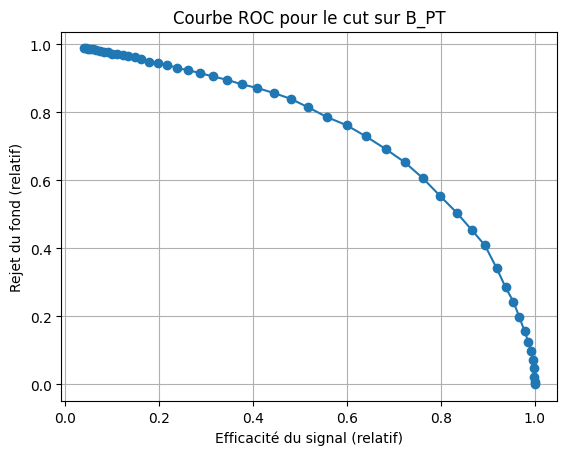

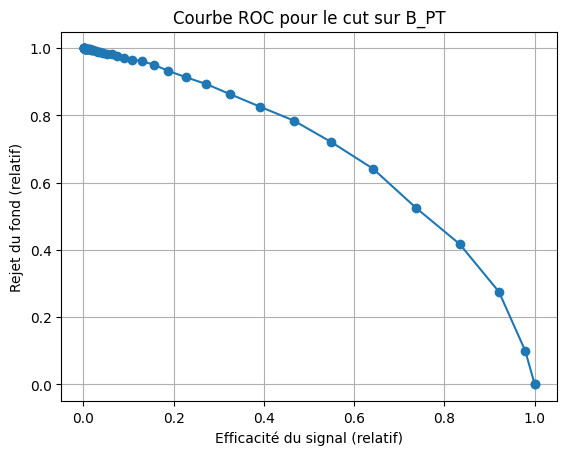

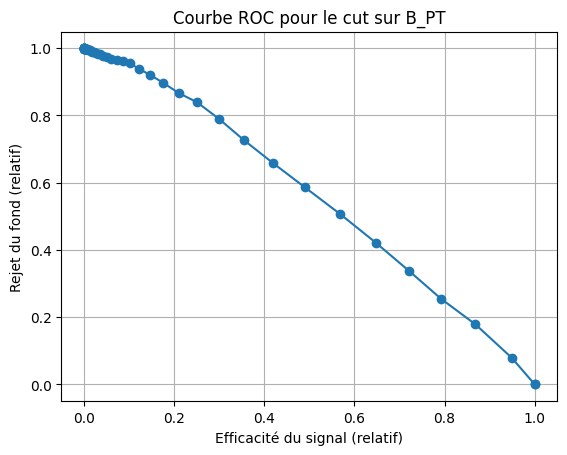

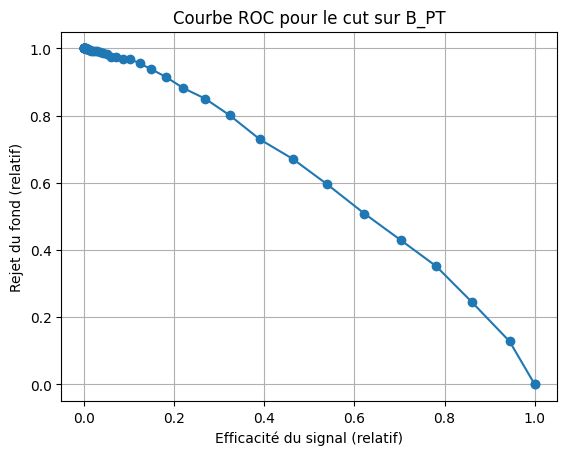

In [19]:


def tracer_roc(discriminant, signal_mask, mass_total, seuils, fond_seuil=5600):
    effs = []
    rejs = []

    for seuil in seuils:
        cut_mask = discriminant > seuil

        # Efficacité relative (signal)
        n_signal_tot = ak.sum(signal_mask)
        n_signal_pass = ak.sum(signal_mask & cut_mask)
        eff = n_signal_pass / n_signal_tot if n_signal_tot > 0 else 0

        # Rejet relatif (fond)
        fond_mask = (mass_total > fond_seuil) & ~signal_mask
        n_fond_tot = ak.sum(fond_mask)
        n_fond_pass = ak.sum(fond_mask & cut_mask)
        rej = 1 - (n_fond_pass / n_fond_tot) if n_fond_tot > 0 else 0

        effs.append(eff)
        rejs.append(rej)

    # Tracer la ROC
    plt.plot(effs, rejs, marker='o')
    plt.xlabel("Efficacité du signal (relatif)")
    plt.ylabel("Rejet du fond (relatif)")
    plt.title("Courbe ROC pour le cut sur B_PT")
    plt.grid(True)
    plt.show()
seuils = np.linspace(0, 20000, 50)  # valeurs de B_PT à tester
tracer_roc(b_pt_presel, signal_mask_preselb, mass_total, seuils)
tracer_roc(k_pt_presel, signal_mask_preselk, mass_total, seuils)
tracer_roc(e1_pt_presel, signal_mask_presele1, mass_total, seuils)
tracer_roc(e2_pt_presel, signal_mask_presele2, mass_total, seuils)

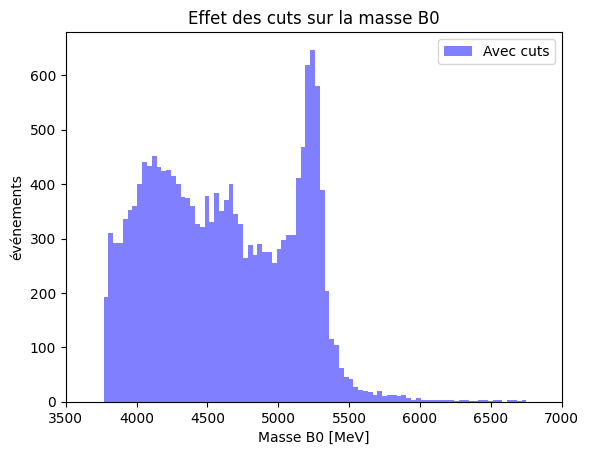

In [20]:

plt.hist(data_mass_presel_cut, bins=100, alpha=0.5, label="Avec cuts", color="blue")
plt.xlabel("Masse B0 [MeV]")
plt.ylabel("événements")
plt.title("Effet des cuts sur la masse B0")
plt.legend()
plt.xlim(3500, 7000)
plt.show()


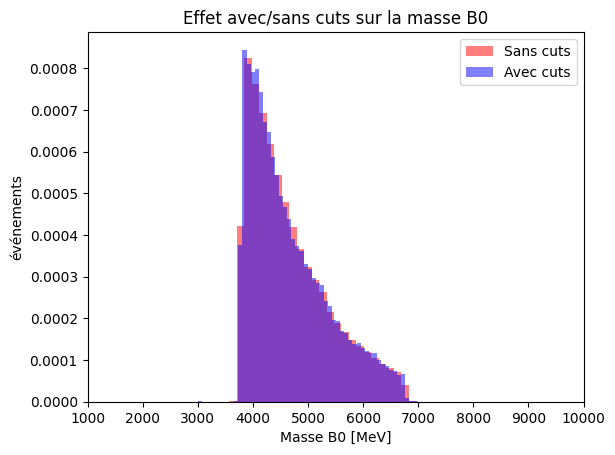

In [21]:


plt.hist(data_mass, bins=100, density=True, alpha=0.5, label="Sans cuts", color="red")
plt.hist(data_mass[cut_total], bins=100, density=True, alpha=0.5, label="Avec cuts", color="blue")
plt.xlabel("Masse B0 [MeV]")
plt.ylabel("événements")
plt.title("Effet avec/sans cuts sur la masse B0")


plt.legend()
plt.xlim(1000,10000)
plt.show()


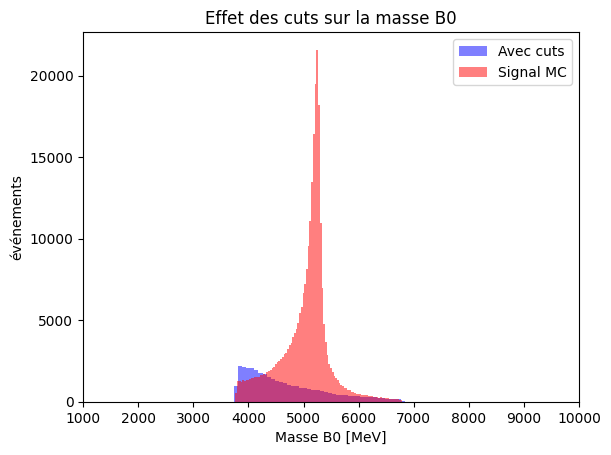

In [22]:

plt.hist(data_mass[cut_total], bins=100, alpha=0.5, label="Avec cuts", color="blue")
plt.hist(mc_mass, bins=100, alpha=0.5, label="Signal MC", color="red")
plt.xlabel("Masse B0 [MeV]")
plt.ylabel("événements")
plt.title("Effet des cuts sur la masse B0")
plt.legend()
plt.xlim(1000,10000)
plt.show()

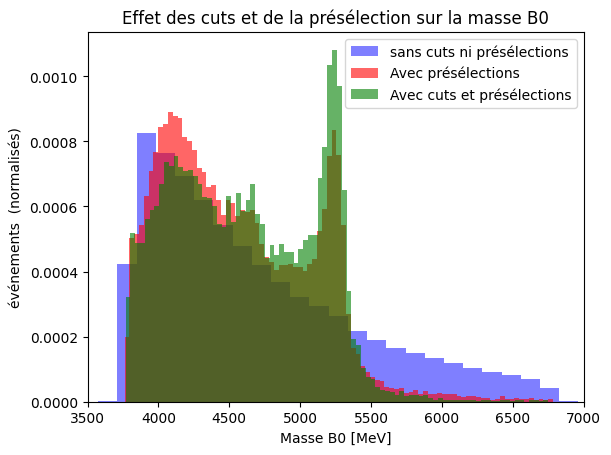

In [23]:


plt.hist(data_mass, bins=100, density=True, alpha=0.5, label="sans cuts ni présélections", color="blue")
plt.hist(data_mass_presel, bins=100, density=True, alpha=0.6, label="Avec présélections", color="red")
plt.hist(data_mass_presel_cut, bins=100, density=True, alpha=0.6, label="Avec cuts et présélections", color="green")
plt.xlabel("Masse B0 [MeV]")
plt.ylabel("événements  (normalisés)")
plt.title("Effet des cuts et de la présélection sur la masse B0")
plt.legend()
plt.xlim(3500,7000)
plt.show()

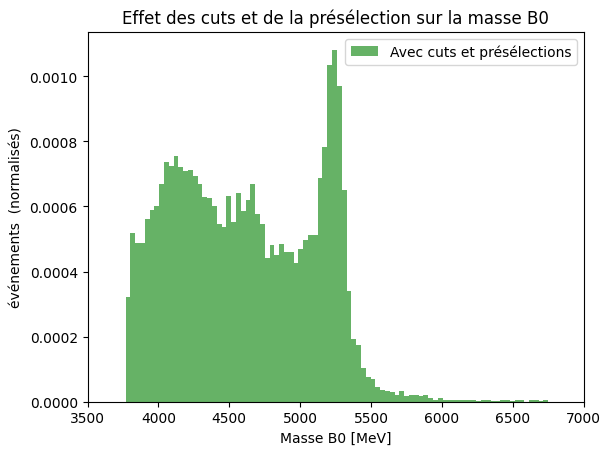

In [28]:
plt.hist(data_mass_presel_cut, bins=100, density=True, alpha=0.6, label="Avec cuts et présélections", color="green")
plt.xlabel("Masse B0 [MeV]")
plt.ylabel("événements  (normalisés)")
plt.title("Effet des cuts et de la présélection sur la masse B0")
plt.legend()
plt.xlim(3500,7000)
plt.show()

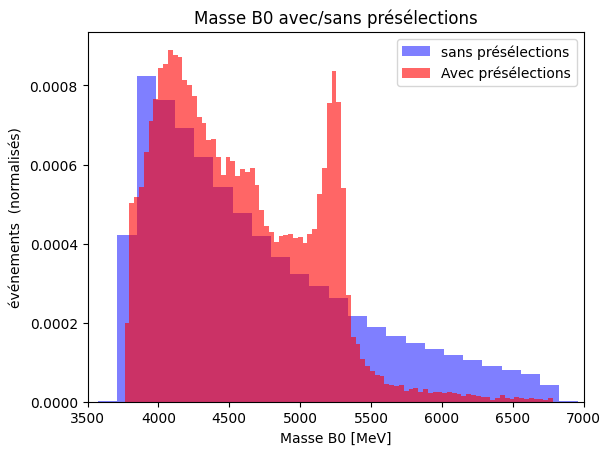

✅ Efficacité du signal : 43.80%
❌ Rejet du fond       : 0.00%
43.8047028900581


(np.float64(43.8), 0, None)

In [24]:
plt.hist(data_mass, bins=100, density=True, alpha=0.5, label="sans présélections", color="blue")
plt.hist(data_mass_presel, bins=100, density=True, alpha=0.6, label="Avec présélections", color="red")
plt.xlabel("Masse B0 [MeV]")
plt.ylabel("événements  (normalisés)")
plt.title("Masse B0 avec/sans présélections")
plt.legend()
plt.xlim(3500,7000)
plt.show()

calculer_eff_rejet(signal_maskm, signal_mask_preselm)

In [25]:
n_mc_total   = len(mc_mass)
n_mc_pass    = ak.sum(presel_mc)

eff_presel = n_mc_pass / n_mc_total * 100
print(f"✅ Efficacité de la présélection (signal MC) : {eff_presel:.2f}%")


background_mask = data_mass > 5600

n_data_total = ak.sum(background_mask)
n_data_pass  = ak.sum(background_mask & presel_data)

rej_presel = (1 - n_data_pass / n_data_total) * 100
print(f"❌ Rejet de la présélection (fond) : {rej_presel:.2f}%") # seulement la présélection


✅ Efficacité de la présélection (signal MC) : 12.56%
❌ Rejet de la présélection (fond) : 99.71%


In [26]:
def efficacité_rejet_relative_fusionnée(signal_mask_presel, cut_mask, mass_total, background_mass_threshold=5600):
    """
    Calcule l'efficacité relative du signal et le rejet relatif du fond
    à partir d'un tableau fusionné MC + data après présélection.

    Arguments :
    - signal_mask_presel : booléen (True pour MC, False pour data), même taille que mass_total
    - cut_mask           : booléen indiquant quels événements passent les cuts
    - mass_total         : tableau de masse (MC + data), même taille que signal_mask
    - background_mass_threshold : seuil pour définir le fond (ex: B_M > 5600)

    Retourne :
    - efficacité relative (%), rejet relatif (%)
    """

    # ---- MC (signal) ----
    n_mc_presel = ak.sum(signal_mask_presel)
    n_mc_pass = ak.sum(signal_mask_presel & cut_mask)
    eff_relative = n_mc_pass / n_mc_presel * 100 if n_mc_presel > 0 else 0

    # ---- Fond (data) dans sideband ----
    background_mask = (mass_total > background_mass_threshold) & ~signal_mask_presel
    n_bkg_presel = ak.sum(background_mask)
    n_bkg_pass = ak.sum(background_mask & cut_mask)
    rej_relative = (1 - n_bkg_pass / n_bkg_presel) * 100 if n_bkg_presel > 0 else 0

    print(f"✅ Efficacité relative du signal : {eff_relative:.2f}%")
    print(f"❌ Rejet relatif du fond        : {rej_relative:.2f}%")

    return eff_relative, rej_relative

efficacité_rejet_relative_fusionnée(signal_mask_preselm,cut_total,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_preselb,cut_maskb,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_preselk,cut_maskk,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_presele1,cut_maske1,mass_total)
print()
efficacité_rejet_relative_fusionnée(signal_mask_presele2,cut_maske2,mass_total)


✅ Efficacité relative du signal : 49.55%
❌ Rejet relatif du fond        : 80.31%

✅ Efficacité relative du signal : 99.87%
❌ Rejet relatif du fond        : 3.01%

✅ Efficacité relative du signal : 58.56%
❌ Rejet relatif du fond        : 69.74%

✅ Efficacité relative du signal : 93.25%
❌ Rejet relatif du fond        : 9.51%

✅ Efficacité relative du signal : 92.80%
❌ Rejet relatif du fond        : 14.84%


(np.float64(92.79615187567597), np.float64(14.839961202715813))

μ = 4833.9 MeV   σ = 359.2 MeV   a = 1.42e-03   b = 0.8


/var/folders/9x/rv7gxm3n3hd33zjlkc92yqs80000gn/T/ipykernel_1041/4207481976.py:16: RuntimeWarning: overflow encountered in exp
  expo  = np.exp(-a * m) + b


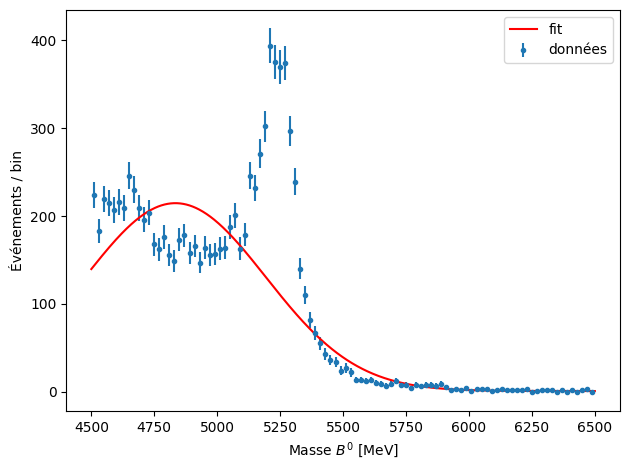

In [31]:

# ------------------------------------------------------------------
# 1) Construire l’histogramme de la masse
# ------------------------------------------------------------------
bin_edges   = np.linspace(4500, 6500, 101)      # 100 bins de 20 MeV
bin_width = bin_edges[1] - bin_edges[0]         
mass_np = np.asarray(data_mass_presel_cut)           # conversion explicite
counts, _ = np.histogram(mass_np, bins=bin_edges)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
errors      = np.sqrt(np.maximum(counts, 1))                     # barre d’erreur ±√N

# ------------------------------------------------------------------
# 2) Définir le modèle gaussienne + exponentielle
# ------------------------------------------------------------------
def model(m, A, mu, sigma, a, b):
    gauss = A / (np.sqrt(2*np.pi)*sigma) * np.exp(-(m-mu)**2 / (2*sigma**2))
    expo  = np.exp(-a * m) + b
    return gauss + expo

# ------------------------------------------------------------------
# 3) Ajuster les paramètres
# ------------------------------------------------------------------
#p0 = (counts.max(), 5280, 20, 1e-3, counts.min())
p0 = (counts.max()*bin_width, 5280, 20, 1e-3, counts.min())   # valeurs de départ
pars, cov = curve_fit(model,
                      bin_centers, counts,
                      p0=p0,
                      sigma=errors,
                      absolute_sigma=True)

A, mu, sigma, a, b = pars
print(f"μ = {mu:.1f} MeV   σ = {sigma:.1f} MeV   a = {a:.2e}   b = {b:.1f}")

# ------------------------------------------------------------------
# 4) Tracer le résultat
# ------------------------------------------------------------------
m_plot = np.linspace(bin_edges[0], bin_edges[-1], 800)
plt.errorbar(bin_centers, counts, yerr=errors, fmt=".", label="données")
plt.plot(m_plot, model(m_plot, *pars), color="red", label="fit")
plt.xlabel("Masse $B^0$ [MeV]")
plt.ylabel("Événements / bin")
plt.legend(); plt.tight_layout(); plt.show()



µ = 5234.2 MeV   σ = 40.0 MeV   A = 437 evt


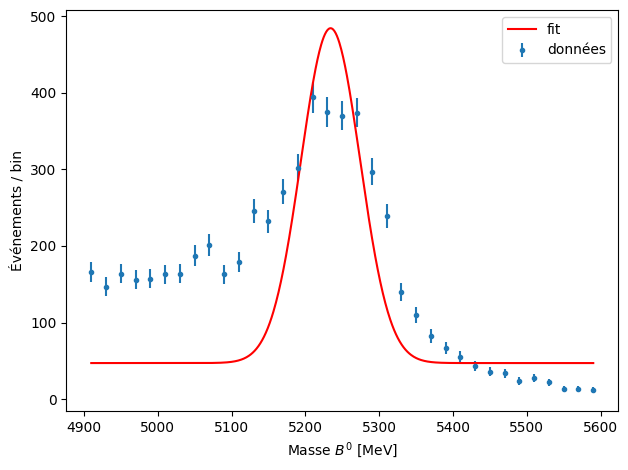

χ²/ndf = 1785.1 / 30 = 59.50


In [ ]:
def model(m, A, mu, sigma, a, b):
    gauss = A * np.exp(-(m-mu)**2 / (2*sigma**2))          # aire = A
    expo  = np.exp(-a*m) + b
    return gauss + expo

# --- fenêtre autour du pic
sel = (bin_centers > 4900) & (bin_centers < 5600)
x, y, e = bin_centers[sel], counts[sel], errors[sel]

# largeur de bin (utile pour p0)
bin_edges   = np.linspace(4900, 5600, 51)
bw = bin_edges[1] - bin_edges[0]

p0     = (y.max()*bw, 5280, 25, 1e-3, y.min())
bounds = ([0, 5200,  10, 0, 0],
          [np.inf, 5350, 40, 1e-2, np.inf])

pars, cov = curve_fit(model, x, y, p0=p0, bounds=bounds,
                      sigma=e, absolute_sigma=True)

A, mu, sigma, a, b = pars
print(f"µ = {mu:.1f} MeV   σ = {sigma:.1f} MeV   A = {A:.0f} evt")

# tracé
m_plot = np.linspace(x.min(), x.max(), 800)
plt.errorbar(x, y, yerr=e, fmt=".", label="données")
plt.plot(m_plot, model(m_plot, *pars), color="red", label="fit")
plt.xlabel("Masse $B^0$ [MeV]")
plt.ylabel("Événements / bin")
plt.legend(); plt.tight_layout(); plt.show()

fit_vals   = model(x, *pars)             # même abscisses que y
residuals  = (y - fit_vals) / e
chi2       = np.sum(residuals**2)
ndf        = len(x) - len(pars)
print(f"χ²/ndf = {chi2:.1f} / {ndf} = {chi2/ndf:.2f}")
